In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/')
import os

# TODO: Fill in the Google Drive path where you uploaded the files 
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab/final_project/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['COVID_combined', 'Normal', 'maskHE2_labels.csv', 'test', 'validation', 'ReadMe.gdoc', 'training.ipynb', 'training', 'train_dataset.npy', 'valid_dataset.npy', 'train_dataset_jiahong.npy', 'valid_dataset_jiahong.npy', 'Model_LungSegmentation', 'Model_Without_Lungseg', 'images_nomask', 'HE_output2.zip', 'Things to be done for Final Project.gdoc', 'Siamese_Learning.ipynb', 'grad_labels.csv', 'create_label.ipynb', 'Matching_code', 'val_labels.csv', 'test_labels.csv', 'train_labels.csv', 'Copy of Siamese_Learning.ipynb', 'COVID-19 X-Ray Image Classification Using Transfer Learning and Contrastive Learning.gslides', 'Training_VGG16_CrossValidation_WithLungMasking.ipynb', 'grad_labels_4.csv']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image

import copy

**Transform dataset- Data Augmentation**

In [ ]:
train_transforms = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.CenterCrop(224),   #I thing CenterCrop makes more sense than randomCrop, because the lung is ususally at the center of the image
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  #used for data augmentation

val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

test_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

grad_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

train_csv = os.path.join(GOOGLE_DRIVE_PATH,'train_labels.csv')
val_csv = os.path.join(GOOGLE_DRIVE_PATH,'val_labels.csv')
test_csv = os.path.join(GOOGLE_DRIVE_PATH,'test_labels.csv')
grad_csv = os.path.join(GOOGLE_DRIVE_PATH,'grad_labels.csv')

class_numbers = 2

test_path = os.path.join(GOOGLE_DRIVE_PATH,"test")
train_path = os.path.join(GOOGLE_DRIVE_PATH,"training")
val_path = os.path.join(GOOGLE_DRIVE_PATH,"validation")

batch_size = 32

**adding the Kfold**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [ ]:
train_df1 = pd.read_csv(train_csv)
train_df2 = pd.read_csv(val_csv)
train_df=train_df2.append(train_df1,ignore_index=True,sort=True)


grad_df = pd.read_csv(grad_csv)

#grad_df_4 = grad_df.iloc[[0,1,4,5],:]
#print(grad_df_4)

#grad_df_4.to_csv("drive/My Drive/Colab/final_project/grad_labels_4.csv", index = False)

grad_csv_4 = os.path.join(GOOGLE_DRIVE_PATH,'grad_labels_4.csv')

In [ ]:
train_features=train_df['Images']
train_target=train_df['encoded_labels']
n_splits = 5 # Number of K-fold Splits

splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True).split(train_features, train_target))
splits

[(array([   0,    1,    2, ..., 6506, 6507, 6508]),
  array([   7,    8,   13, ..., 6474, 6479, 6499])),
 (array([   1,    2,    4, ..., 6506, 6507, 6508]),
  array([   0,    3,    6, ..., 6501, 6502, 6504])),
 (array([   0,    2,    3, ..., 6505, 6506, 6507]),
  array([   1,    9,   10, ..., 6495, 6498, 6508])),
 (array([   0,    1,    3, ..., 6504, 6507, 6508]),
  array([   2,    4,    5, ..., 6503, 6505, 6506])),
 (array([   0,    1,    2, ..., 6505, 6506, 6508]),
  array([  11,   12,   14, ..., 6490, 6497, 6507]))]

**VGG16**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True)
#print(vgg16.classifier[6].out_features) # 1000 

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer

features.extend([nn.Linear(num_features, class_numbers)]) # Add our layer with 2 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

vgg16 = vgg16.to(device)

print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

**DataLoader For Test**

In [ ]:
class CovidDataset(Dataset):  # 0 stands for Covid and 1 stands for Normal

  def __init__(self, csv_file, root_dir, transform=None):
    self.XRay_image = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.XRay_image)

  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.XRay_image.iloc[idx, 0])
        #print(img_name)
        image = io.imread(img_name)  #print(image)     #print(np.max(image))
        image = np.expand_dims(image,axis = 2) #(512,512) but the input of VGG should have three channels
        image = np.repeat(image, 3, axis=2) #(512, 512, 3)
        #print(type(image))   #print(image.shape)

        image = Image.fromarray(image, 'RGB') # change to PIL image inorder to use transformation
        #plt.figure()
        #plt.imshow(image)
        label = int(self.XRay_image.iloc[idx, 2])
        print(label)
        #lable = label.astype('float')
        #print(label)

        if self.transform:
            image = self.transform(image)

        sample = (image, label)
        return sample


In [ ]:
test_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
test_dataset = CovidDataset(csv_file=test_csv, root_dir=test_path, transform=test_transforms)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

**Dataloader Function For Cross validation-Training**

In [ ]:
class CovidDataset_Train(Dataset):  # 0 stands for Covid and 1 stands for Normal

  def __init__(self, pandas_file,root_dir1, root_dir,transform=None):
    self.XRay_image = pandas_file
    self.root_dir = root_dir
    self.root_dir1 = root_dir1
    self.transform = transform

  def __len__(self):
    return len(self.XRay_image)

  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name1 = os.path.join(self.root_dir, self.XRay_image.iloc[idx,0])
        img_name2 = os.path.join(self.root_dir1, self.XRay_image.iloc[idx,0])
        if os.path.exists(img_name1):
          true_name=img_name1
        else:
          true_name=img_name2

        #print(img_name)
        image = io.imread(true_name)  #print(image)     #print(np.max(image))
        image = np.expand_dims(image,axis = 2) #(512,512) but the input of VGG should have three channels
        image = np.repeat(image, 3, axis=2) #(512, 512, 3)
        #print(type(image))   #print(image.shape)

        image = Image.fromarray(image, 'RGB') # change to PIL image inorder to use transformation
        #plt.figure()
        #plt.imshow(image)
        label = int(self.XRay_image.iloc[idx, 1])
        #lable = label.astype('float')
        #print(label)

        if self.transform:
            image = self.transform(image)

        sample = (image, label)
        return sample

**Test_Accuracy**

In [ ]:
model=vgg16

model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545/VGG16_Cross_Validation.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
test_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
test_dataset = CovidDataset(csv_file=test_csv, root_dir=test_path, transform=train_transforms)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
test_csv

'/content/drive/MyDrive/EECS545/test_labels.csv'

In [ ]:
model.eval()
result=[]
running_corrects=0
for inputs, labels in test_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model(inputs)
  _, preds = torch.max(outputs, 1)
  running_corrects += torch.sum(preds == labels)
  result.append(np.array(preds.detach().cpu(),dtype='float32'))



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
from scipy.io import savemat

mdic = {"Result": np.asarray(result)}
savemat("VGG16_Test_Index.mat", mdic)

In [ ]:

epoch_acc = float(running_corrects.double()/len(test_loader))
print(epoch_acc)

0.9336099585062241


**Load trained model**

In [ ]:
model=vgg16

model.load_state_dict(torch.load(GOOGLE_DRIVE_PATH + 'Model_LungSegmentation/VGG16_Cross_Validation.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#load test data
Grad_loader=CovidDataset(csv_file=grad_csv, root_dir=test_path, transform=test_transforms)
grad_dataloader = torch.utils.data.DataLoader(Grad_loader, batch_size = 1, shuffle=False)

dataloader_iter = iter(grad_dataloader)

**Grad-CAM toolbox**

In [ ]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 10.5MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp37-none-any.whl size=5269 sha256=a384c21b0dbf0881e704dd89f377fa77b2291679fa08257fda637376bbbcc475
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [ ]:
configs = [dict(model_type='vgg', arch=vgg16, layer_name='features')]
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [ ]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [ ]:
torch_img = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [ ]:
vgg = model
#test_dataset = CovidDataset_Train(pandas_file=Test_Final_pd, root_dir1=COVID_path, root_dir = Normal_path, transform=torch_img)
#test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

grad_dataloader = torch.utils.data.DataLoader(Grad_loader, batch_size = 1, shuffle=False)
dataloader_iter = iter(grad_dataloader)

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
#img, _ = next(iter(test_loader))
#pred = vgg(img.to(device)).argmax(dim=1)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:

images = []
#test_dataset = CovidDataset_Train(pandas_file=Test_Final_pd, root_dir1=COVID_path, root_dir = Normal_path, transform=torch_img)
#test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
#dataloder_iter = iter(test_loader)
for gradcam, gradcam_pp in cams:
  for i in range(8):
    #test_dataset = CovidDataset_Train(pandas_file=Test_Final_pd, root_dir1=COVID_path, root_dir = Normal_path, transform=torch_img)
    #test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# set the evaluation mode
    #vgg.eval()

# get the image from the dataloader
    img, labels = next(dataloader_iter)
    pred = vgg(img.to(device)).argmax(dim=1)
    mask, _ = gradcam(img.to(device))
    heatmap, result = visualize_cam(mask, img)

    #mask_pp, _ = gradcam_pp(img.to(device))
    #heatmap_pp, result_pp = visualize_cam(mask_pp, img)
    
    images.extend([img[0,:,:,:].cpu(), heatmap, result])
    
grid_image = make_grid(images, nrow=3)

0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


0
0
0
1
1
1
1


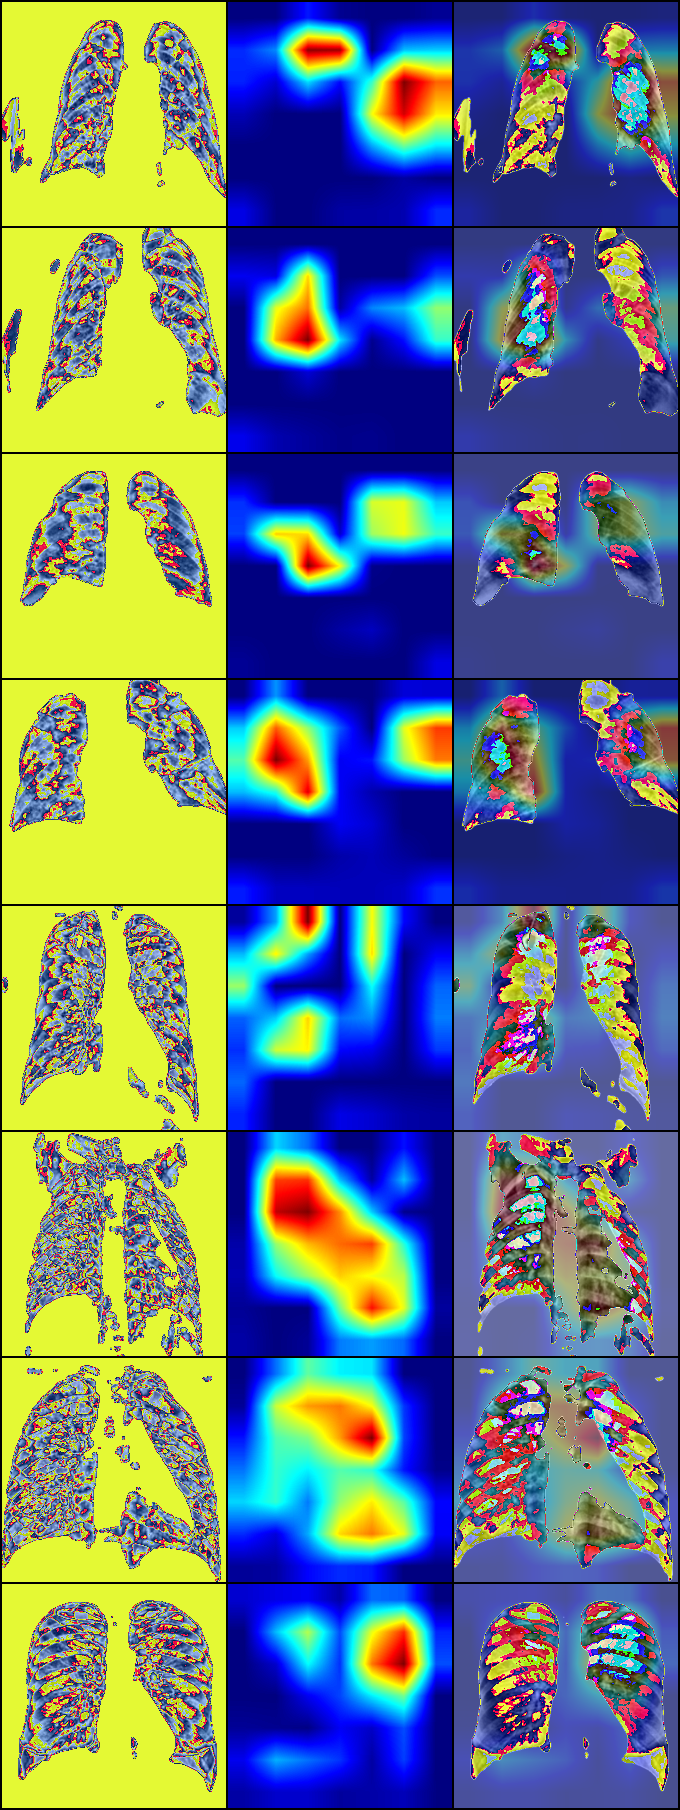

In [ ]:
transforms.ToPILImage()(grid_image)

**Grad-cam2**

In [ ]:
#load test data
Grad_loader=CovidDataset(csv_file=grad_csv_4, root_dir=test_path, transform=grad_transforms)
grad_dataloader = torch.utils.data.DataLoader(Grad_loader, batch_size = 1, shuffle=False)

dataloader_iter = iter(grad_dataloader)

In [ ]:
# Extract  pretrained activations
class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()
  
class SaveGradients():
    features=None
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, grad_input, grad_output):
        self.features = ((grad_output[0].detach().cpu()).data).numpy()
    def remove(self):
        self.hook.remove()

#final_layer = model_ft._modules.get('features')[10]['denselayer16']  #get the layer of features ->denseblock4 ->denselayer16

final_layer = vgg._modules.get('features')[29] #get the layer before fc 
#final_layer = vgg._modules.get('avgpool')
print(final_layer)
activated_features = SaveFeatures(final_layer)
activated_gradients = SaveGradients(final_layer)

ReLU(inplace=True)


In [ ]:
def cam_img(feature_map, grads):
    _, nc, h, w = feature_map.shape
    cam = np.zeros((h,w), dtype=np.float32)	
    #print(cam.shape)
    grads = grads[0]
    #print(grads.shape)	
    weights = np.mean(grads, axis=(1,2))
    #print(weights.shape)
    for i, w in enumerate(weights):
        cam += w * feature_map[0, i, :, :]
    #print(cam.shape)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    return cam

In [ ]:
model_ft = vgg

proba = []
heatmaps = []
original_images = []
predict_labels = []
gt_labels = []

for i in range(4):
  img, labels = next(dataloader_iter)
  img = img.to(device)

  #forward
  output = model_ft(img)
  probabilities = F.softmax(output,dim=1).data.squeeze()
  proba.append((str(np.round(np.max(probabilities.cpu().detach().numpy())*100,2)))+'%')

  pred_idx = np.argmax(probabilities.cpu().detach().numpy(),axis=0)
  predict_labels.append(pred_idx)
  gt_labels.append(labels)

  cur_image = img.cpu().numpy().transpose((0, 2, 3, 1))
  #print(cur_image.shape)
  original_images.append(cur_image)

  # backward
  model_ft.zero_grad()
  class_loss = output[0,pred_idx]
  class_loss.backward()

  #print(activated_features.features.shape)
  #print(activated_gradients.features.shape)

  grad_img = cam_img(activated_features.features, activated_gradients.features)
  #activated_features.remove()
  heatmaps.append(grad_img)
    
print(len(proba), len(heatmaps),len(predict_labels))
print(proba)
print(predict_labels)
print(gt_labels)

0
0
1
1
4 4 4
['73.96%', '60.21%', '87.99%', '97.15%']
[0, 0, 0, 1]
[tensor([0]), tensor([0]), tensor([1]), tensor([1])]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


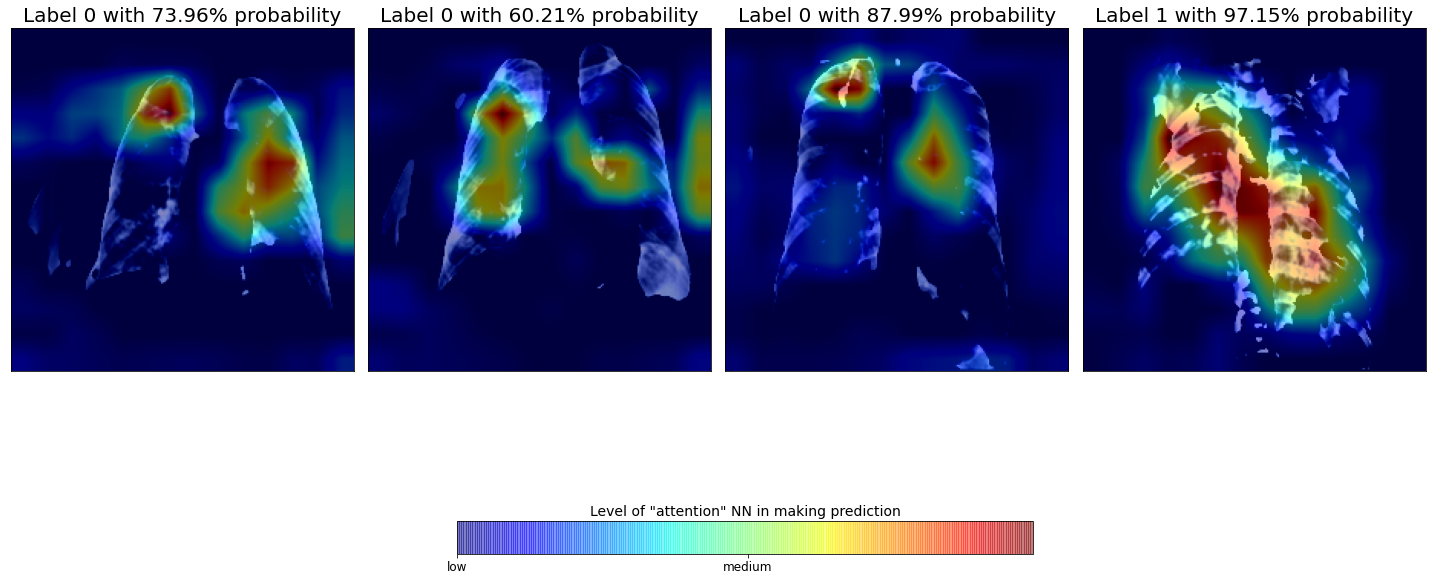

In [ ]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
fig=plt.figure(figsize=(20,15))


for i in range(0, len(original_images)):
    img = original_images[i]
    mask = heatmaps[i]
    ax = fig.add_subplot(2, 4,i +1,xticks=[], yticks=[])
    fig.tight_layout()
    plt.imshow(img[0,:,:,:])
    plt.imshow(cv2.resize(mask, (224,224), interpolation=cv2.INTER_LINEAR), alpha=0.5, cmap='jet');
    ax.set_title('Label %d with %s probability' % (predict_labels[i], proba[i]),fontsize=20)
    #ax.set_title('Label %d ' % (predict_labels[i]),fontsize=12)
    
#cax = fig.add_axes([0.3, 0.42, 0.4, 0.04]) # place where be map
cax = fig.add_axes([0.32, 0.42, 0.4, 0.03]) # place where be map
clb = plt.colorbar(cax=cax, orientation='horizontal',ticks=[0, 0.5, 1])
clb.ax.set_title('Level of "attention" NN in making prediction',fontsize=14)
clb.ax.set_xticklabels(['low', 'medium', 'high'],fontsize=12)

plt.show()